# ENSF 544 Final Project: Music Genre Prediction
## April 2nd, 2024

## Names:
- Chace Nielson 30045674
- Tony Vo 30091585

Our dataset was obtained from [this GTZAN dataset on Kaggle for music genre classification](https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification).

In this project, we use the GTZAN dataset to categorize 1000 songs across 10 musical genres, each represented by 100 audio files. Recognized for its widespread usage in music genre recognition within the machine learning community, the GTZAN dataset consists of audio files collected between 2000 and 2001 from multiple sources, such as the collectors' personal CD collections, radio broadcasts, and direct microphone recordings.

For the dataset version hosted on Kaggle, the creators shortened each song to 30 seconds. They extracted various audio features from these clips, including the zero-crossing rate, tempo, harmony, and spectral centroid. This dataset has 58 feature columns, a column for the file name, and a target vector column that specifies the genre.

This project will use Random Forest, XGBoost, and Support Vector Machine (SVM) classifiers to predict song genres. We start by scaling the data within pipelines using `StandardScaler` to ensure the data is normalized before training. Subsequently, we will use `GridSearchCV` to find the best parameters for each model. The effectiveness of our classifiers will be evaluated using the accuracy score, providing a quantitative measure of performance to compare the models effectively.

## Imports/Setup

In [1]:
import os
import warnings

import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from xgboost import XGBClassifier

%matplotlib inline
warnings.filterwarnings("ignore")

# Data Path Setup
This section reads the CSV file, creates a dataframe for the dataset, and gets basic information, such as the first ten rows and the different genres.

In [5]:
general_path = "features_30_sec.csv"
data = pd.read_csv(f"{general_path}")
data.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [6]:
print("The following are the genres of audio files. The features of each audio file are represented in the CSV file.")
genres = data["label"].unique().tolist()
print(genres)

The following are the genres of audio files. The features of each audio file are represented in the CSV file.
['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


# Data Exploration
This section further delves into the dataset, including:
* The column data types
* The non-null and null values count
* The duplicate rows count

In [7]:
# Summary of the dataset: column data types and non-null counts
print("\nDataset info:")
data.info()

# Summary statistics for numerical columns
print("\nSummary statistics for numerical columns:")
print(data.describe())

# Check for any null values in each column
print("\nNumber of null values in each column:")
print(data.isnull().sum())

# Check for duplicates
print("\nNumber of duplicate rows:", data.duplicated().sum())

# Check the distribution of the label column (i.e., the target vector)
print("\nDistribution of labels (target variable):")
print(data["label"].value_counts())


Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 60 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   filename                 1000 non-null   object 
 1   length                   1000 non-null   int64  
 2   chroma_stft_mean         1000 non-null   float64
 3   chroma_stft_var          1000 non-null   float64
 4   rms_mean                 1000 non-null   float64
 5   rms_var                  1000 non-null   float64
 6   spectral_centroid_mean   1000 non-null   float64
 7   spectral_centroid_var    1000 non-null   float64
 8   spectral_bandwidth_mean  1000 non-null   float64
 9   spectral_bandwidth_var   1000 non-null   float64
 10  rolloff_mean             1000 non-null   float64
 11  rolloff_var              1000 non-null   float64
 12  zero_crossing_rate_mean  1000 non-null   float64
 13  zero_crossing_rate_var   1000 non-null   float64
 14  harmony_me

Text(0, 0.5, 'BPM')

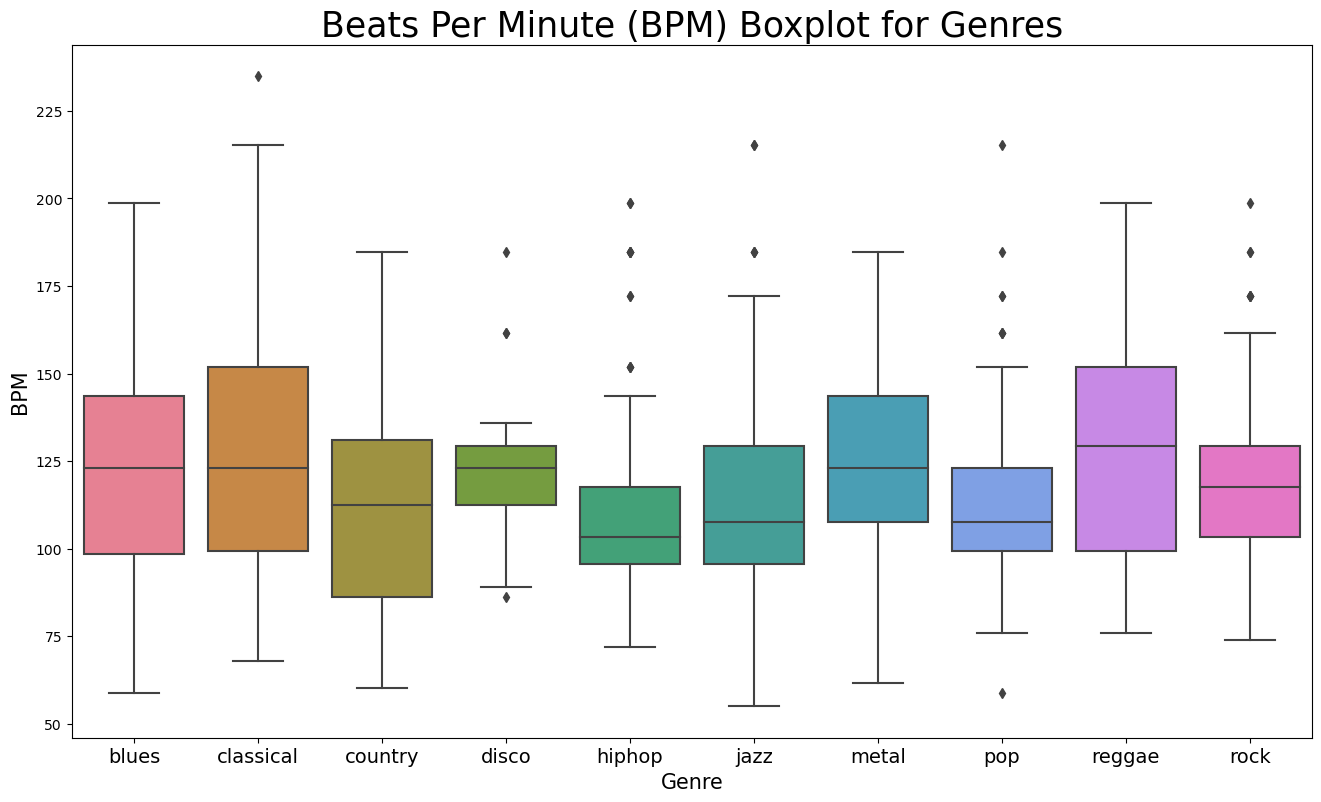

In [8]:
x = data[["label", "tempo"]]

f, ax = plt.subplots(figsize=(16, 9));
sns.boxplot(x = "label", y = "tempo", data = x, palette = "husl");

plt.title("Beats Per Minute (BPM) Boxplot for Genres", fontsize = 25)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Genre", fontsize = 15)
plt.ylabel("BPM", fontsize = 15)

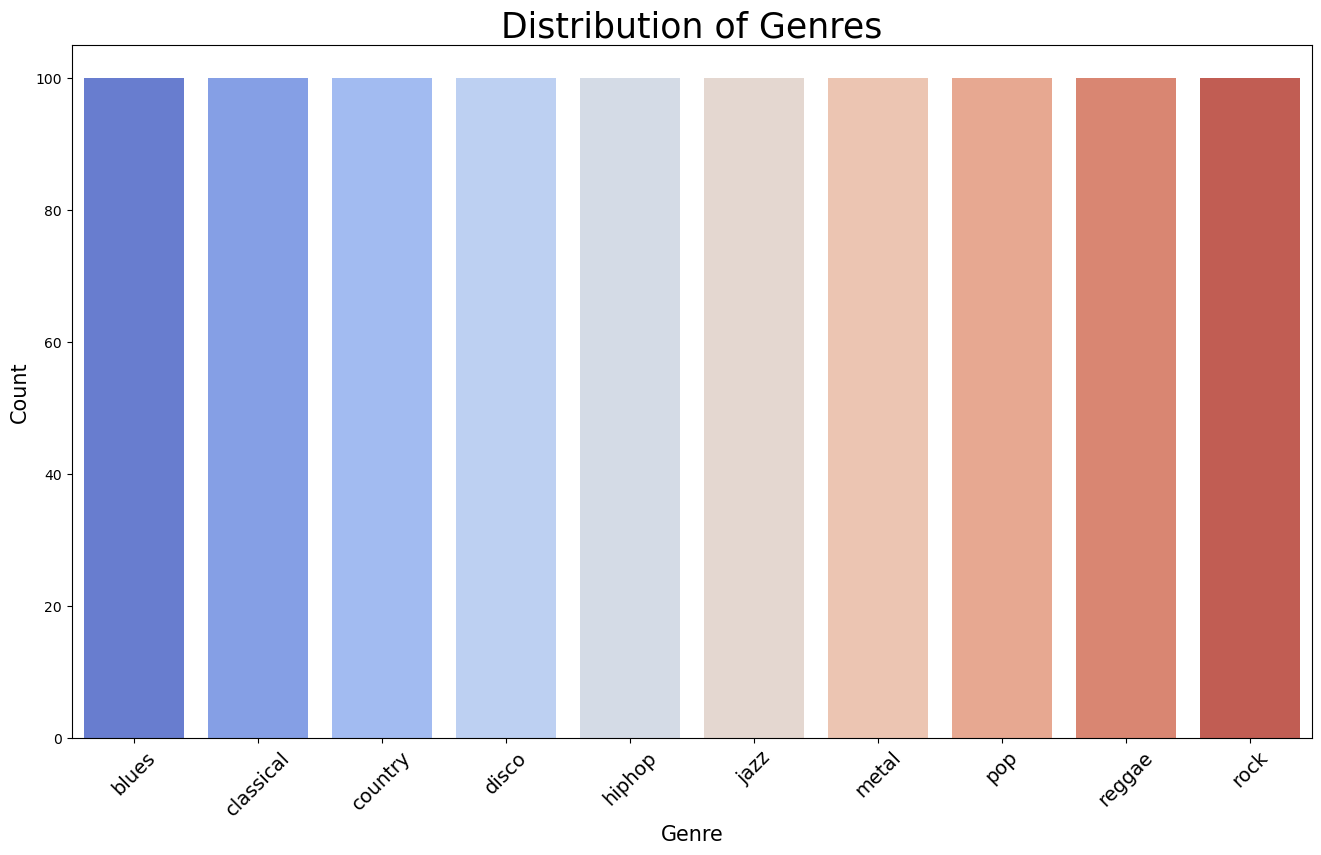

In [9]:
plt.figure(figsize=(16, 9))
sns.countplot(data=data, x="label", palette="coolwarm")
plt.title("Distribution of Genres", fontsize=25)
plt.xticks(rotation=45, fontsize=14)
plt.xlabel("Genre", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.show()

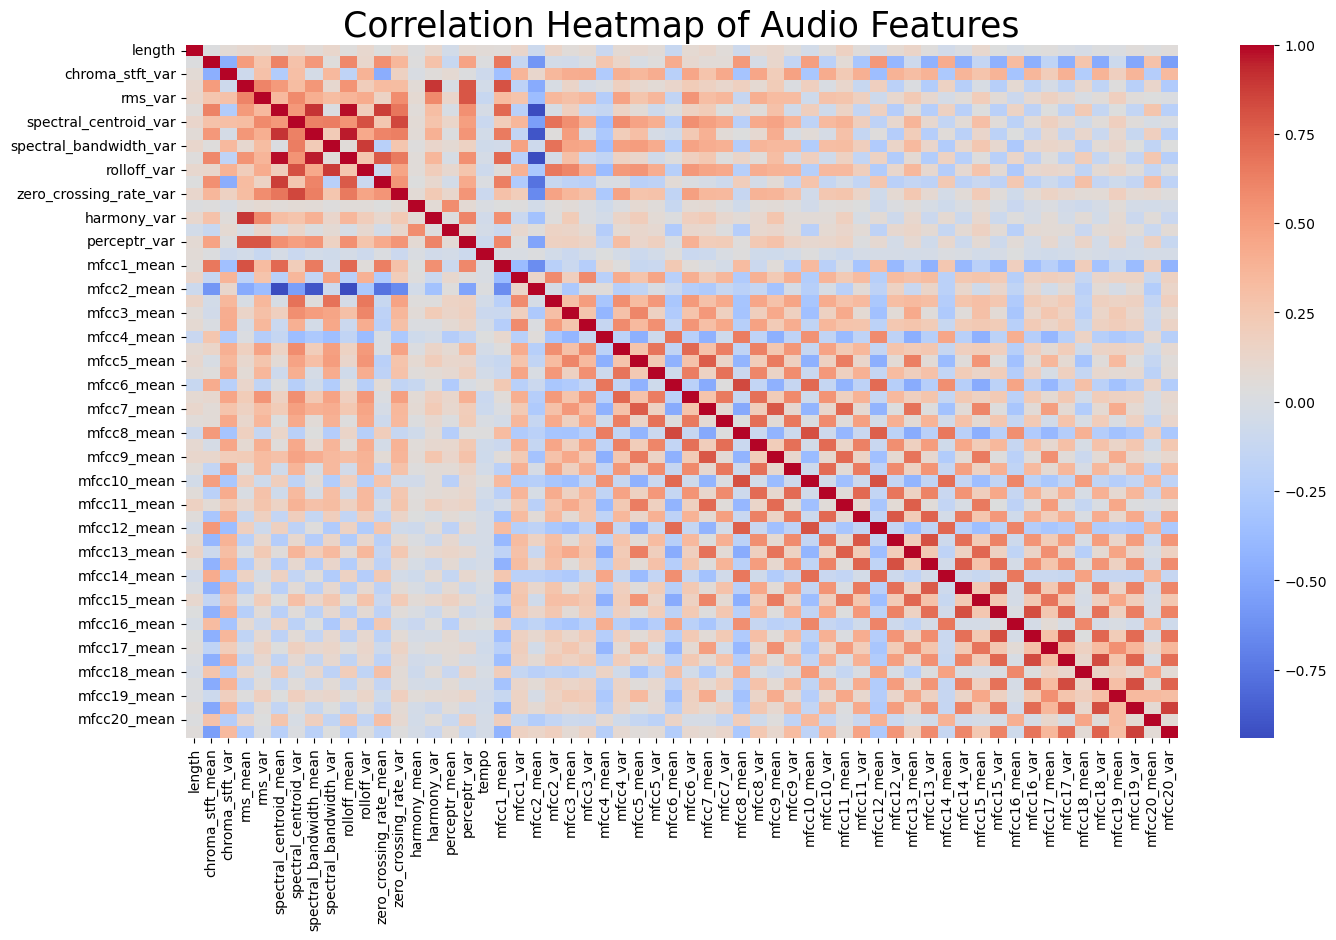

In [10]:
plt.figure(figsize=(16, 9))
corr = data.drop(["label", "filename"], axis=1).corr()
sns.heatmap(corr, cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap of Audio Features", fontsize=25)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

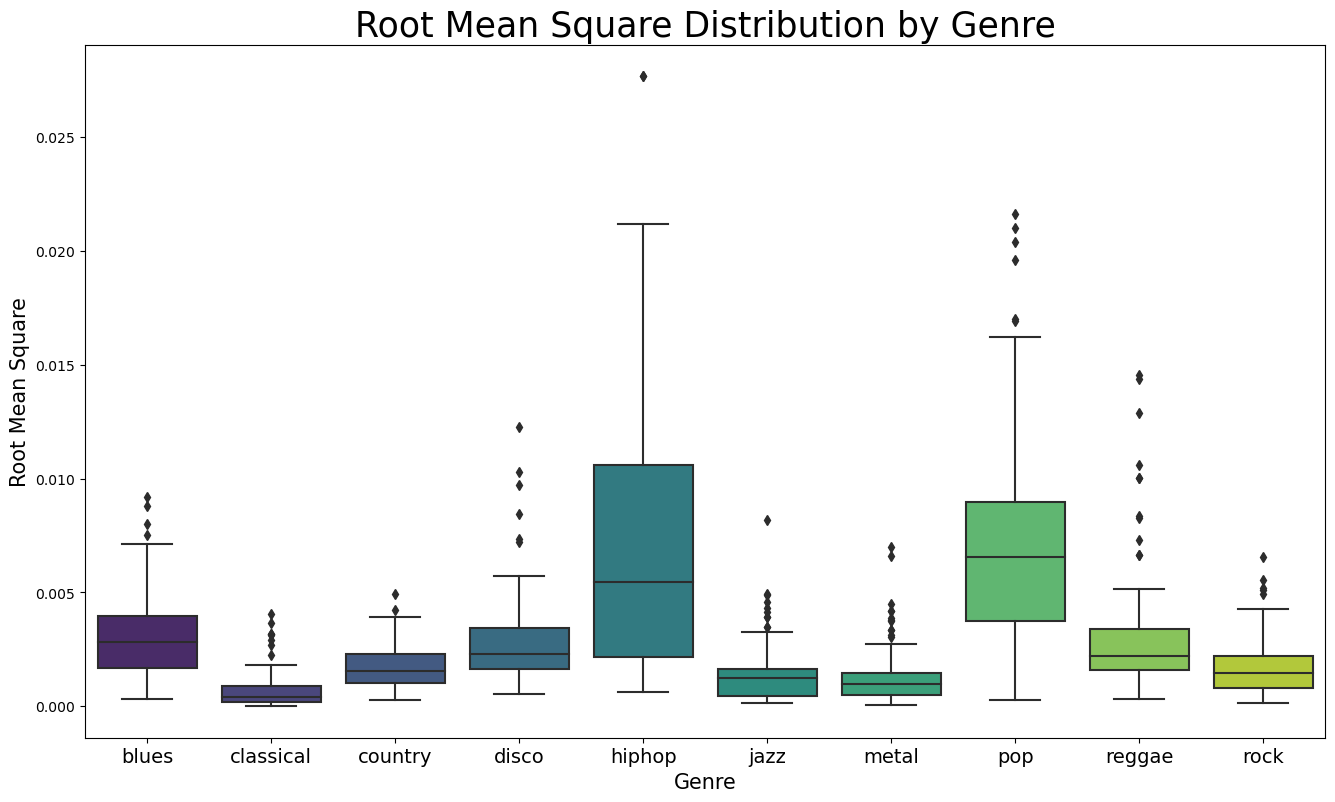

In [11]:
plt.figure(figsize=(16, 9))
sns.boxplot(x="label", y="rms_var", data=data, palette="viridis")
plt.title("Root Mean Square Distribution by Genre", fontsize=25)
plt.xticks(fontsize=14)
plt.yticks(fontsize=10)
plt.xlabel("Genre", fontsize=15)
plt.ylabel("Root Mean Square", fontsize=15)
plt.show()

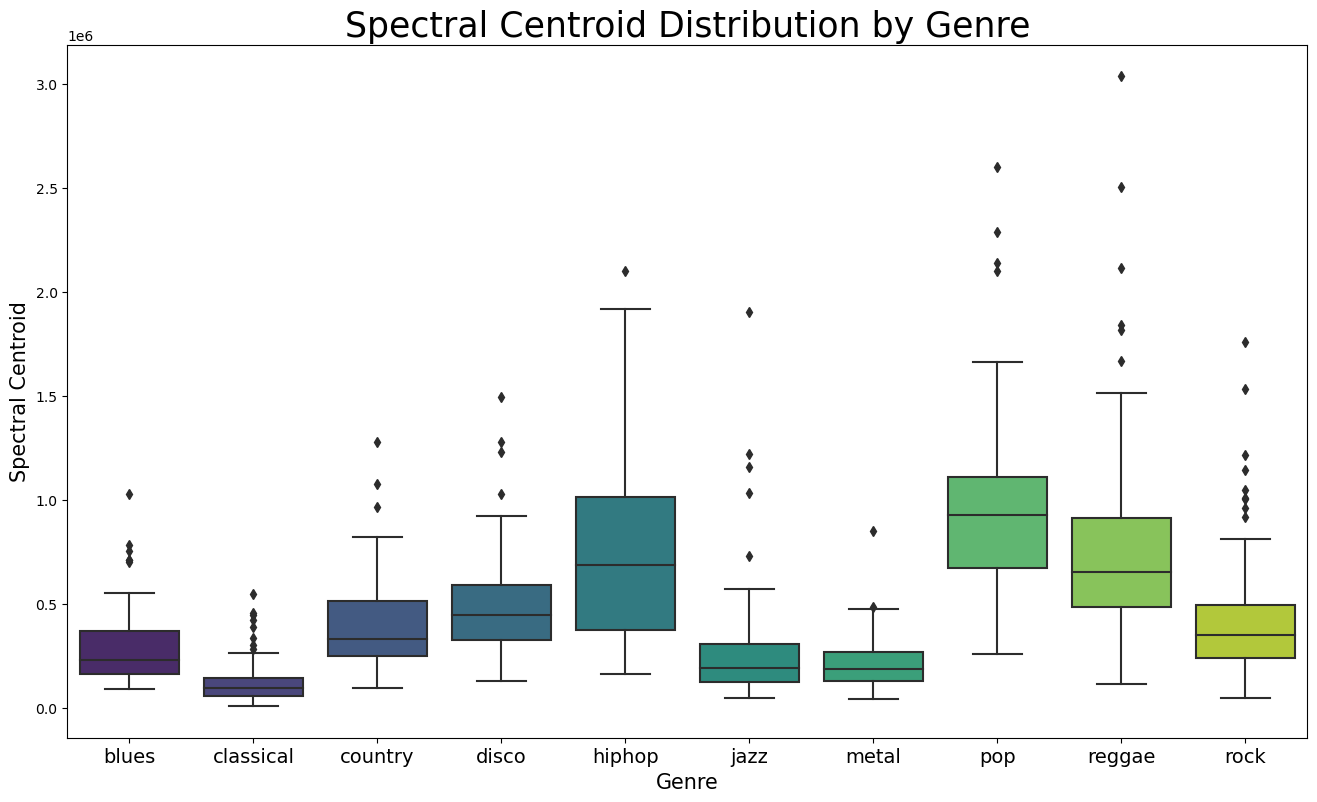

In [12]:
plt.figure(figsize=(16, 9))
sns.boxplot(x="label", y="spectral_centroid_var", data=data, palette="viridis")
plt.title("Spectral Centroid Distribution by Genre", fontsize=25)
plt.xticks(fontsize=14)
plt.yticks(fontsize=10)
plt.xlabel("Genre", fontsize=15)
plt.ylabel("Spectral Centroid", fontsize=15)
plt.show()

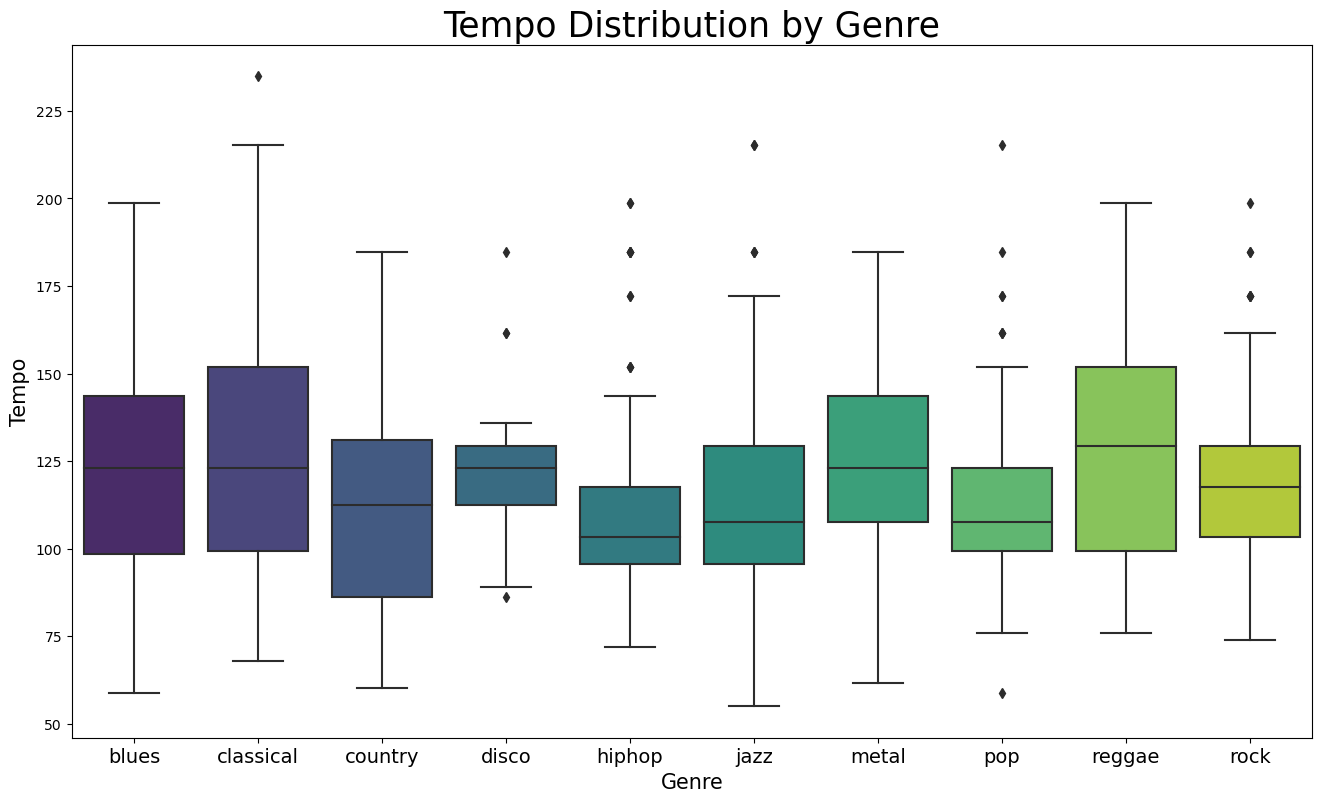

In [13]:
plt.figure(figsize=(16, 9))
sns.boxplot(x="label", y="tempo", data=data, palette="viridis")
plt.title("Tempo Distribution by Genre", fontsize=25)
plt.xticks(fontsize=14)
plt.yticks(fontsize=10)
plt.xlabel("Genre", fontsize=15)
plt.ylabel("Tempo", fontsize=15)
plt.show()

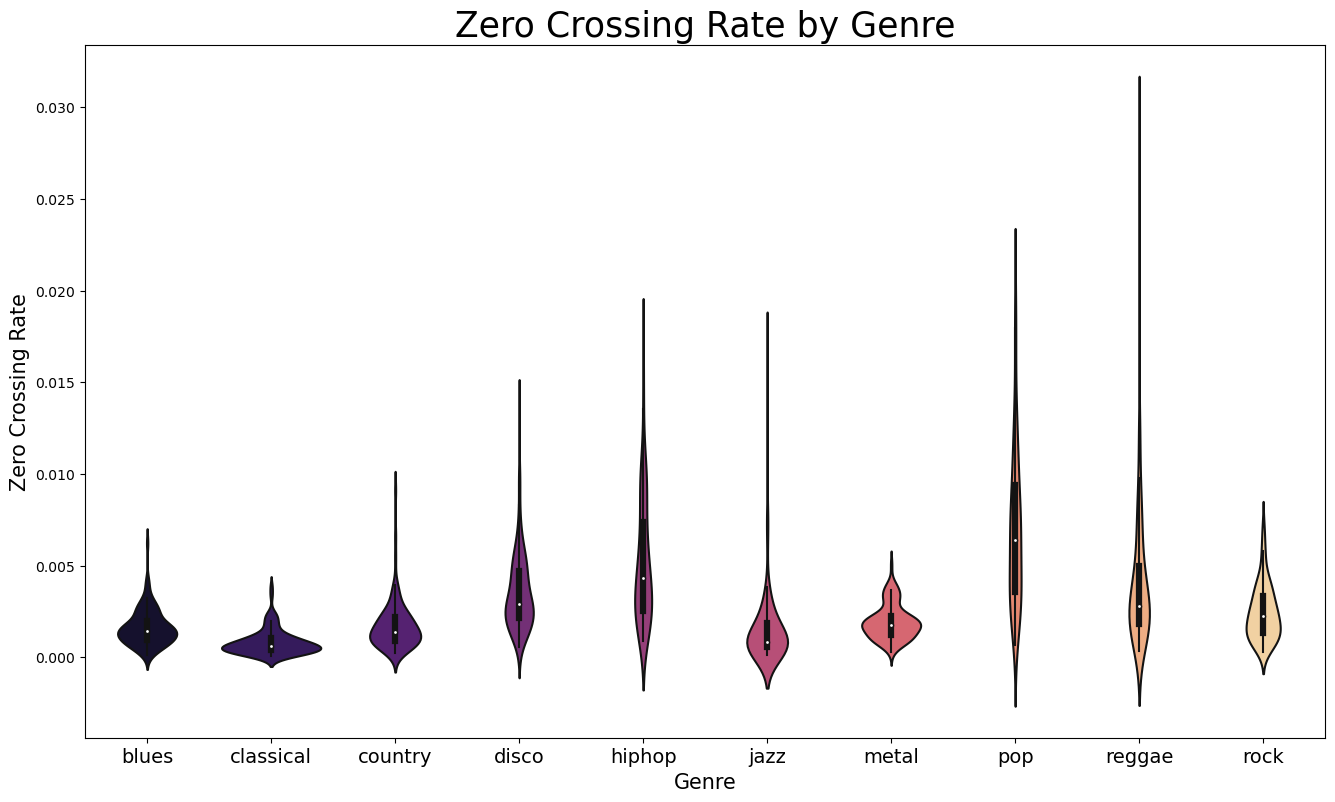

In [14]:
plt.figure(figsize=(16, 9))
sns.violinplot(x="label", y="zero_crossing_rate_var", data=data, palette="magma")
plt.title("Zero Crossing Rate by Genre", fontsize=25)
plt.xticks(fontsize=14)
plt.yticks(fontsize=10)
plt.xlabel("Genre", fontsize=15)
plt.ylabel("Zero Crossing Rate", fontsize=15)
plt.show()

# Creating the feature set, target vector, and test/train split

This section uses the dataframe without the label and filename columns as the feature set and the label column as the target vector. Furthermore, using `LabelEncoder`, each genre is assigned a number. The function `decode_genre` is used to decode between the number and the genre's full name.

In [15]:
# Separate features and target label
X = data.drop(["label", "filename"], axis=1)
y = data["label"]

# Encode the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Function to decode an encoded genre number back to the genre name
def decode_genre(genre_num):
    # Number from 0 to 9
    # 0 - blues, 1 - classical, 2 - country, 3 - disco, 4 - hiphop, 5 - jazz, 6 - metal, 7 - pop, 8 - reggae, 9 - rock
    # The input to inverse_transform needs to be array-like, thus [genre_num]
    genre_name = label_encoder.inverse_transform([genre_num])[0]
    return genre_name

# Grid Search
Next, the `evaluate_and_return_best_model_with_gridsearch` function is defined to use `GridSearchCV` with each model. Given a pipeline and parameter grid, a grid search is conducted and fitted for each model. Then, the best model and training and testing accuracy scores for the best model are found. Finally, the accuracy scores and classification report are printed before the function returns the best model.

As stated in the introduction, we are using three models:
- Random Forest
- XGBoost
- SVC

For each model, a pipeline is created with two steps. The first step is to apply the `StandardScaler` to the training data. Then, the second step is to develop and use the model. Next, a parameter grid with various parameters is defined for each model. The large number of parameters in each parameter grid will help us to find the best model with a high training score.

In [16]:
# Evaluates a pipeline and returns the best model
def evaluate_and_return_best_model_with_gridsearch(pipeline, param_grid, X_train, X_test, y_train, y_test, cv=5):
    # Initialize GridSearchCV with the provided pipeline and parameter grid
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=cv, scoring="accuracy", n_jobs=-1)

    # Fit GridSearchCV to find the best model
    grid_search.fit(X_train, y_train)

    # Get the best estimator (model) from the grid search
    model = grid_search.best_estimator_

    # Predict on both training and testing data using the best model
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculate accuracy on both training and testing data
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Print the best parameters, training, and testing accuracy
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Testing Accuracy: {test_accuracy:.4f}\n")

    # Print classification report for testing data
    print(classification_report(y_test, y_test_pred))

    # Return the best model
    return model

In [17]:
# Define the pipeline
rf_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("rf", RandomForestClassifier(random_state=42))
])

# Define the parameter grid for the Random Forest classifier
param_grid_rf = {
    "rf__n_estimators": [50,100, 200, 300, 400, 500],
    "rf__max_depth": [10, 20, 30, None],
    "rf__min_samples_split": [1, 2, 5, 10],
    "rf__min_samples_leaf": [1, 2, 4,6]
}

print("Evaluating Random Forest...")
randomForest_model = evaluate_and_return_best_model_with_gridsearch(rf_pipeline, param_grid_rf, X_train, X_test, y_train, y_test)

Evaluating Random Forest...
Best Parameters: {'rf__max_depth': 20, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 500}
Training Accuracy: 0.9988
Testing Accuracy: 0.7750

              precision    recall  f1-score   support

           0       0.65      0.75      0.70        20
           1       1.00      1.00      1.00        13
           2       0.72      0.67      0.69        27
           3       0.80      0.76      0.78        21
           4       0.60      0.80      0.69        15
           5       1.00      0.91      0.95        22
           6       0.89      0.96      0.92        25
           7       0.83      0.77      0.80        13
           8       0.71      0.65      0.68        23
           9       0.63      0.57      0.60        21

    accuracy                           0.78       200
   macro avg       0.78      0.78      0.78       200
weighted avg       0.78      0.78      0.78       200



In [18]:
# Define the pipeline for XGBoost
xgb_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("xgb", XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42))  # XGBoost classifier
])
# Define the parameter grid for XGBoost
param_grid_xgb = {
    "xgb__learning_rate": [0.01, 0.1],
    "xgb__n_estimators": [100, 500],
    "xgb__max_depth": [3, 6],
    "xgb__subsample": [0.7, 0.9],
    "xgb__colsample_bytree": [0.7, 0.9],
    "xgb__reg_lambda": [1, 10],
}

print("\nEvaluating XGBoost...")
XGBoost_model = evaluate_and_return_best_model_with_gridsearch(xgb_pipeline, param_grid_xgb, X_train, X_test, y_train, y_test)


Evaluating XGBoost...
Best Parameters: {'xgb__colsample_bytree': 0.7, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 6, 'xgb__n_estimators': 500, 'xgb__reg_lambda': 10, 'xgb__subsample': 0.9}
Training Accuracy: 0.9988
Testing Accuracy: 0.8000

              precision    recall  f1-score   support

           0       0.74      0.85      0.79        20
           1       1.00      1.00      1.00        13
           2       0.79      0.70      0.75        27
           3       0.73      0.76      0.74        21
           4       0.68      0.87      0.76        15
           5       1.00      0.95      0.98        22
           6       0.92      0.92      0.92        25
           7       0.71      0.92      0.80        13
           8       0.81      0.57      0.67        23
           9       0.65      0.62      0.63        21

    accuracy                           0.80       200
   macro avg       0.80      0.82      0.80       200
weighted avg       0.81      0.80      0.80       200

In [19]:
# Define the pipeline for SVC
svm_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(random_state=42))  # Support Vector Classifier
])

# Define the parameter grid for SVC
param_grid_svm = {
    "svm__C": [0.1, 1, 10, 100],
    "svm__gamma": ["scale", "auto", 0.01, 0.1, 1],
    "svm__kernel": ["rbf", "poly", "sigmoid"]
}
print("\nEvaluating SVM...")
SVM_model = evaluate_and_return_best_model_with_gridsearch(svm_pipeline, param_grid_svm, X_train, X_test, y_train, y_test)


Evaluating SVM...
Best Parameters: {'svm__C': 10, 'svm__gamma': 0.01, 'svm__kernel': 'rbf'}
Training Accuracy: 0.9875
Testing Accuracy: 0.7300

              precision    recall  f1-score   support

           0       0.70      0.80      0.74        20
           1       0.93      1.00      0.96        13
           2       0.68      0.70      0.69        27
           3       0.62      0.71      0.67        21
           4       0.60      0.80      0.69        15
           5       0.90      0.86      0.88        22
           6       0.88      0.88      0.88        25
           7       0.73      0.62      0.67        13
           8       0.67      0.35      0.46        23
           9       0.64      0.67      0.65        21

    accuracy                           0.73       200
   macro avg       0.73      0.74      0.73       200
weighted avg       0.73      0.73      0.72       200



# Ensemble Stacking

In this section, we use an [ensemble stack](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html) which combines all three previous models, and then a final classifier (in our case, `LogisticRegression`) to compute the final output.

By using ensemble stacking, we can create a better model than any of the individual models, and therefore, we will have higher accuracy scores.

In [20]:
# Define base models
base_models = [
    ("rf", make_pipeline(StandardScaler(), randomForest_model)),
    ("xgb", make_pipeline(StandardScaler(), XGBoost_model)),
    ("svm", make_pipeline(StandardScaler(), SVM_model))
]

# Define the final classifier to use in ensemble stack
meta_model = LogisticRegression()

# Define the ensemble stack
stacking_ensemble = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

In [21]:
stacking_ensemble.fit(X_train, y_train)

# Make predictions
y_train_pred = stacking_ensemble.predict(X_train)
y_test_pred = stacking_ensemble.predict(X_test)

# Calculate accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")

Training Accuracy: 0.9988
Testing Accuracy: 0.7900


# Results

The results of each model are as follows:

Keep in mind that the random elements in the models can make the final number differ slightly each run.

* Random Forest
 * Training accuracy: 0.9988
 * Testing accuracy: 0.7750
 * Best model parameters: `{'rf__max_depth': 20, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 500}`
* XGBoost
 * Training accuracy: 0.9988
 * Testing accuracy: 0.7900
 * Best model parameters: `{'xgb__colsample_bytree': 0.9, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 6, 'xgb__n_estimators': 500, 'xgb__reg_lambda': 10, 'xgb__subsample': 0.7}`
* SVC
 * Training accuracy: 0.9875
 * Testing accuracy: 0.7300
 * Best model parameters: `{'svm__C': 10, 'svm__gamma': 0.01, 'svm__kernel': 'rbf'}`
* Ensemble Stack
 * Training accuracy: 0.9988
 * Testing accuracy: 0.7900

Of the individual models, XGBoost is the best model because it has the highest training and testing accuracy scores compared to Random Forest and SVC. To achieve these accuracy scores, `GridSearchCV` found the following parameters for the `XGBoost` model:
* `colsample_bytree`: 0.9
* `learning_rate`: 0.1
* `max_depth`: 6
* `n_estimators`: 500
* `reg_lambda`: 10
* `subsample`: 0.7

The fourth model, Ensemble Stack, combines the previous models and the best parameters associated with each model.  According to the results, the Ensemble Stack model has the same training and testing accuracy scores as the `XGBoost` model.

Since all the training scores are very close to 1.0, it may indicate that our models are nearly perfectly classifying each song into its respective genre. Although it may seem ideal, the discrepancy between the training and testing accuracy scores may indicate that our models must be more balanced because they are learning the training data too well. When the model encounters unseen data, the testing score will be lower than the training score.

The high training scores are not unexpected, given that there are 59 feature columns and 1000 songs. As such, the training scores would be lower if there were fewer feature columns or if there were more songs in this dataset.

Next, the F1 scores will be explored because they take the precision and recall scores into account. As such, the false-positive and false-negative results are considered for the F1 score, allowing us to examine the classification results comprehensively. The range of F1 scores are as follows:
* Random Forest: 0.60 (rock) to 1.00 (classical)
* XGBoost: 0.60 (reggae) to 1.00 (classical)
* SVC: 0.46 (reggae) to 0.96 (classical)

According to the F! scores, all three models classified classical music perfectly (in the Random Forest and XGBoost models) or almost perfectly (in the SVC model). Conversely, the XGBoost and SVC models had the lowest F1 scores for the reggae genre, while the Random Forest had the lowest F1 score for the rock genre.


# Conclusion

In conclusion, while the models show promising results when predicting the genres of songs in the dataset, especially in classifying specific genres, there is room for improvement in handling overfitting and classifying genres with lower F1 scores. Future work could explore alternative modelling strategies, more diverse datasets, or advanced feature engineering techniques to enhance the models' generalization capabilities and accuracy across a broader range of musical genres.

# Testing on Extra Songs
Chace has developed experience with machine learning and genre prediction through a personal project. The code below, which originates from this project, will be utilized to enhance the dataset by incorporating additional songs from his collection. Specifically, the `extract_features` function plays a crucial role by extracting the features from each song file, ensuring they align with the existing dataset's format. This process is vital for maintaining consistency and accuracy in genre prediction.

In [22]:
def extract_features(file_path):
    # Load the audio file
    y, sr = librosa.load(file_path)
    audio_file, _ = librosa.effects.trim(y)

    # Pre-compute some parameters
    hop_length = 512
    n_fft = 2048

    # get features
    tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)
    length = len(audio_file)
    chroma_stft_mean = np.mean(librosa.feature.chroma_stft(y=y, sr=sr, hop_length=hop_length))
    chroma_stft_var = np.var(librosa.feature.chroma_stft(y=y, sr=sr, hop_length=hop_length))
    rms_mean = np.mean(librosa.feature.rms(y=y))
    rms_var = np.var(librosa.feature.rms(y=y))
    spectral_centroid_mean = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    spectral_centroid_var = np.var(librosa.feature.spectral_centroid(y=y, sr=sr))
    spectral_bandwidth_mean = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    spectral_bandwidth_var = np.var(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    rolloff_mean = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
    rolloff_var = np.var(librosa.feature.spectral_rolloff(y=y, sr=sr))
    zero_crossing_rate_mean = np.mean(librosa.feature.zero_crossing_rate(y))
    zero_crossing_rate_var = np.var(librosa.feature.zero_crossing_rate(y))

    # Calculate features
    features = {
        "length": length,
        "chroma_stft_mean":chroma_stft_mean ,
        "chroma_stft_var": chroma_stft_var,
        "rms_mean": rms_mean ,
        "rms_var": rms_var,
        "spectral_centroid_mean": spectral_centroid_mean,
        "spectral_centroid_var": spectral_centroid_var,
        "spectral_bandwidth_mean": spectral_bandwidth_mean,
        "spectral_bandwidth_var": spectral_bandwidth_var,
        "rolloff_mean": rolloff_mean,
        "rolloff_var": rolloff_var,
        "zero_crossing_rate_mean": zero_crossing_rate_mean,
        "zero_crossing_rate_var": zero_crossing_rate_var,
        "tempo": tempo,
    }

    # MFCCs (more features)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    for idx, mfcc in enumerate(mfccs):
        features[f"mfcc{idx+1}_mean"] = np.mean(mfcc)
        features[f"mfcc{idx+1}_var"] = np.var(mfcc)

    # Harmony and Perceptr
    y_harm, y_perc = librosa.effects.hpss(audio_file)
    features["harmony_mean"] = np.mean(y_harm)
    features["harmony_var"] = np.var(y_harm)
    features["perceptr_mean"] = np.mean(y_perc)
    features["perceptr_var"] = np.var(y_perc)

    # Return the features
    return np.array(list(features.values())).reshape(1, -1)

In [23]:
# Function that normalizes the Sound Data
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

In [24]:
def display_audio_plots(filepath):
    y, sr = librosa.load(filepath, sr=None)
    audio_file, _ = librosa.effects.trim(y)

    fig, axes = plt.subplots(4, 2, figsize=(16, 20)) # 4 rows, 2 columns
    fig.tight_layout(pad=3.0)

    # Waveform
    time = np.linspace(0, len(y) / sr, num=len(y))
    axes[0, 0].plot(time, y, color="#A300F9")
    axes[0, 0].set_title("Sound Waves")
    axes[0, 0].set_xlabel("Time (seconds)")
    axes[0, 0].set_ylabel("Amplitude")

    # STFT Magnitude
    n_fft = 2048
    hop_length = 512
    D = np.abs(librosa.stft(audio_file, n_fft=n_fft, hop_length=hop_length))
    DB = librosa.amplitude_to_db(D, ref=np.max)
    librosa.display.specshow(DB, sr=sr, hop_length=hop_length, x_axis="time", y_axis="log", cmap="cool", ax=axes[0, 1])
    axes[0, 1].set_title("Decibels-scaled Spectrogram")
    axes[0, 1].figure.colorbar(plt.cm.ScalarMappable(cmap="cool"), ax=axes[0, 1], format="%+2.0f dB")

    # Harmonic and Percussive components
    y_harm, y_perc = librosa.effects.hpss(audio_file)
    axes[1, 0].plot(y_harm, color="#A300F9", label="Harmonic")
    axes[1, 0].plot(y_perc, color="#FFB100", label="Percussive")
    axes[1, 0].set_title("Harmonic and Percussive Components")
    axes[1, 0].legend()

    # Zero Crossings
    zero_crossings = sum(librosa.zero_crossings(audio_file, pad=False))
    axes[1, 1].text(0.5, 0.5, f"Zero Crossings: {zero_crossings}", horizontalalignment="center", verticalalignment="center", transform=axes[1, 1].transAxes)
    axes[1, 1].axis("off")

    # Spectral Centroids
    spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
    frames = range(len(spectral_centroids))
    t = librosa.frames_to_time(frames)
    normalized_spectral_centroids = normalize(spectral_centroids)
    axes[2, 0].plot(t, normalized_spectral_centroids, color="#FFB100", label="Normalized Spectral Centroids")
    axes[2, 0].set_title("Spectral Centroid")

    # Spectral Rolloff
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)[0]
    normalized_spectral_rolloff = normalize(spectral_rolloff)
    axes[2, 1].plot(t, normalized_spectral_rolloff, color="#FFB100", label="Normalized Spectral Rolloff")
    axes[2, 1].set_title("Spectral Rolloff")

    # MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr)
    librosa.display.specshow(mfccs, sr=sr, x_axis="time", cmap="cool", ax=axes[3, 0])
    axes[3, 0].set_title("MFCCs")

    # Chromagram
    chromagram = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=hop_length)
    librosa.display.specshow(chromagram, sr=sr, hop_length=hop_length, x_axis="time", y_axis="chroma", cmap="coolwarm", ax=axes[3, 1])
    axes[3, 1].set_title("Chromagram")
    axes[3, 1].figure.colorbar(plt.cm.ScalarMappable(cmap="coolwarm"), ax=axes[3, 1], format="%+2.0f dB")

    # Adjusting layout
    plt.tight_layout()
    plt.show()

In [25]:
def get_song_genre(filepath, randomForest_model, XGBoost_model, SVM_model, stacking_ensemble, displayPlots=False):
    # Extract features
    features = extract_features(filepath)

    # Since our models were trained with scaled features, we need to scale the extracted features
    scaler = StandardScaler()
    scaler.fit(X_train)  # Fit on the training data
    scaled_features = scaler.transform(features)

    # Predict the genre with each model
    rf_prediction = randomForest_model.predict(scaled_features)
    xgb_prediction = XGBoost_model.predict(scaled_features)
    svm_prediction = SVM_model.predict(scaled_features)
    ensemble_prediction = stacking_ensemble.predict(scaled_features)

    # Print predictions
    print("-Random Forest Prediction: " + decode_genre(rf_prediction[0]))
    print("-XGBoost Prediction: " + decode_genre(xgb_prediction[0]))
    print("-SVM Prediction: " + decode_genre(svm_prediction[0]))
    print("-Stacking Ensemble Prediction: " + decode_genre(ensemble_prediction[0]))

    if displayPlots:
        display_audio_plots(filepath)


In [32]:
def testFiles(genre):
    filepaths = [   f"genres_original/{genre}/{genre}.00003.wav",
                    f"genres_original/{genre}/{genre}.00016.wav",
                    f"genres_original/{genre}/{genre}.00024.wav",
                ]
    for filepath in filepaths:
        print()
        print(filepath)
        get_song_genre(filepath, randomForest_model, XGBoost_model, SVM_model, stacking_ensemble)

-Random Forest Prediction: classical
-XGBoost Prediction: pop
-SVM Prediction: classical
-Stacking Ensemble Prediction: classical


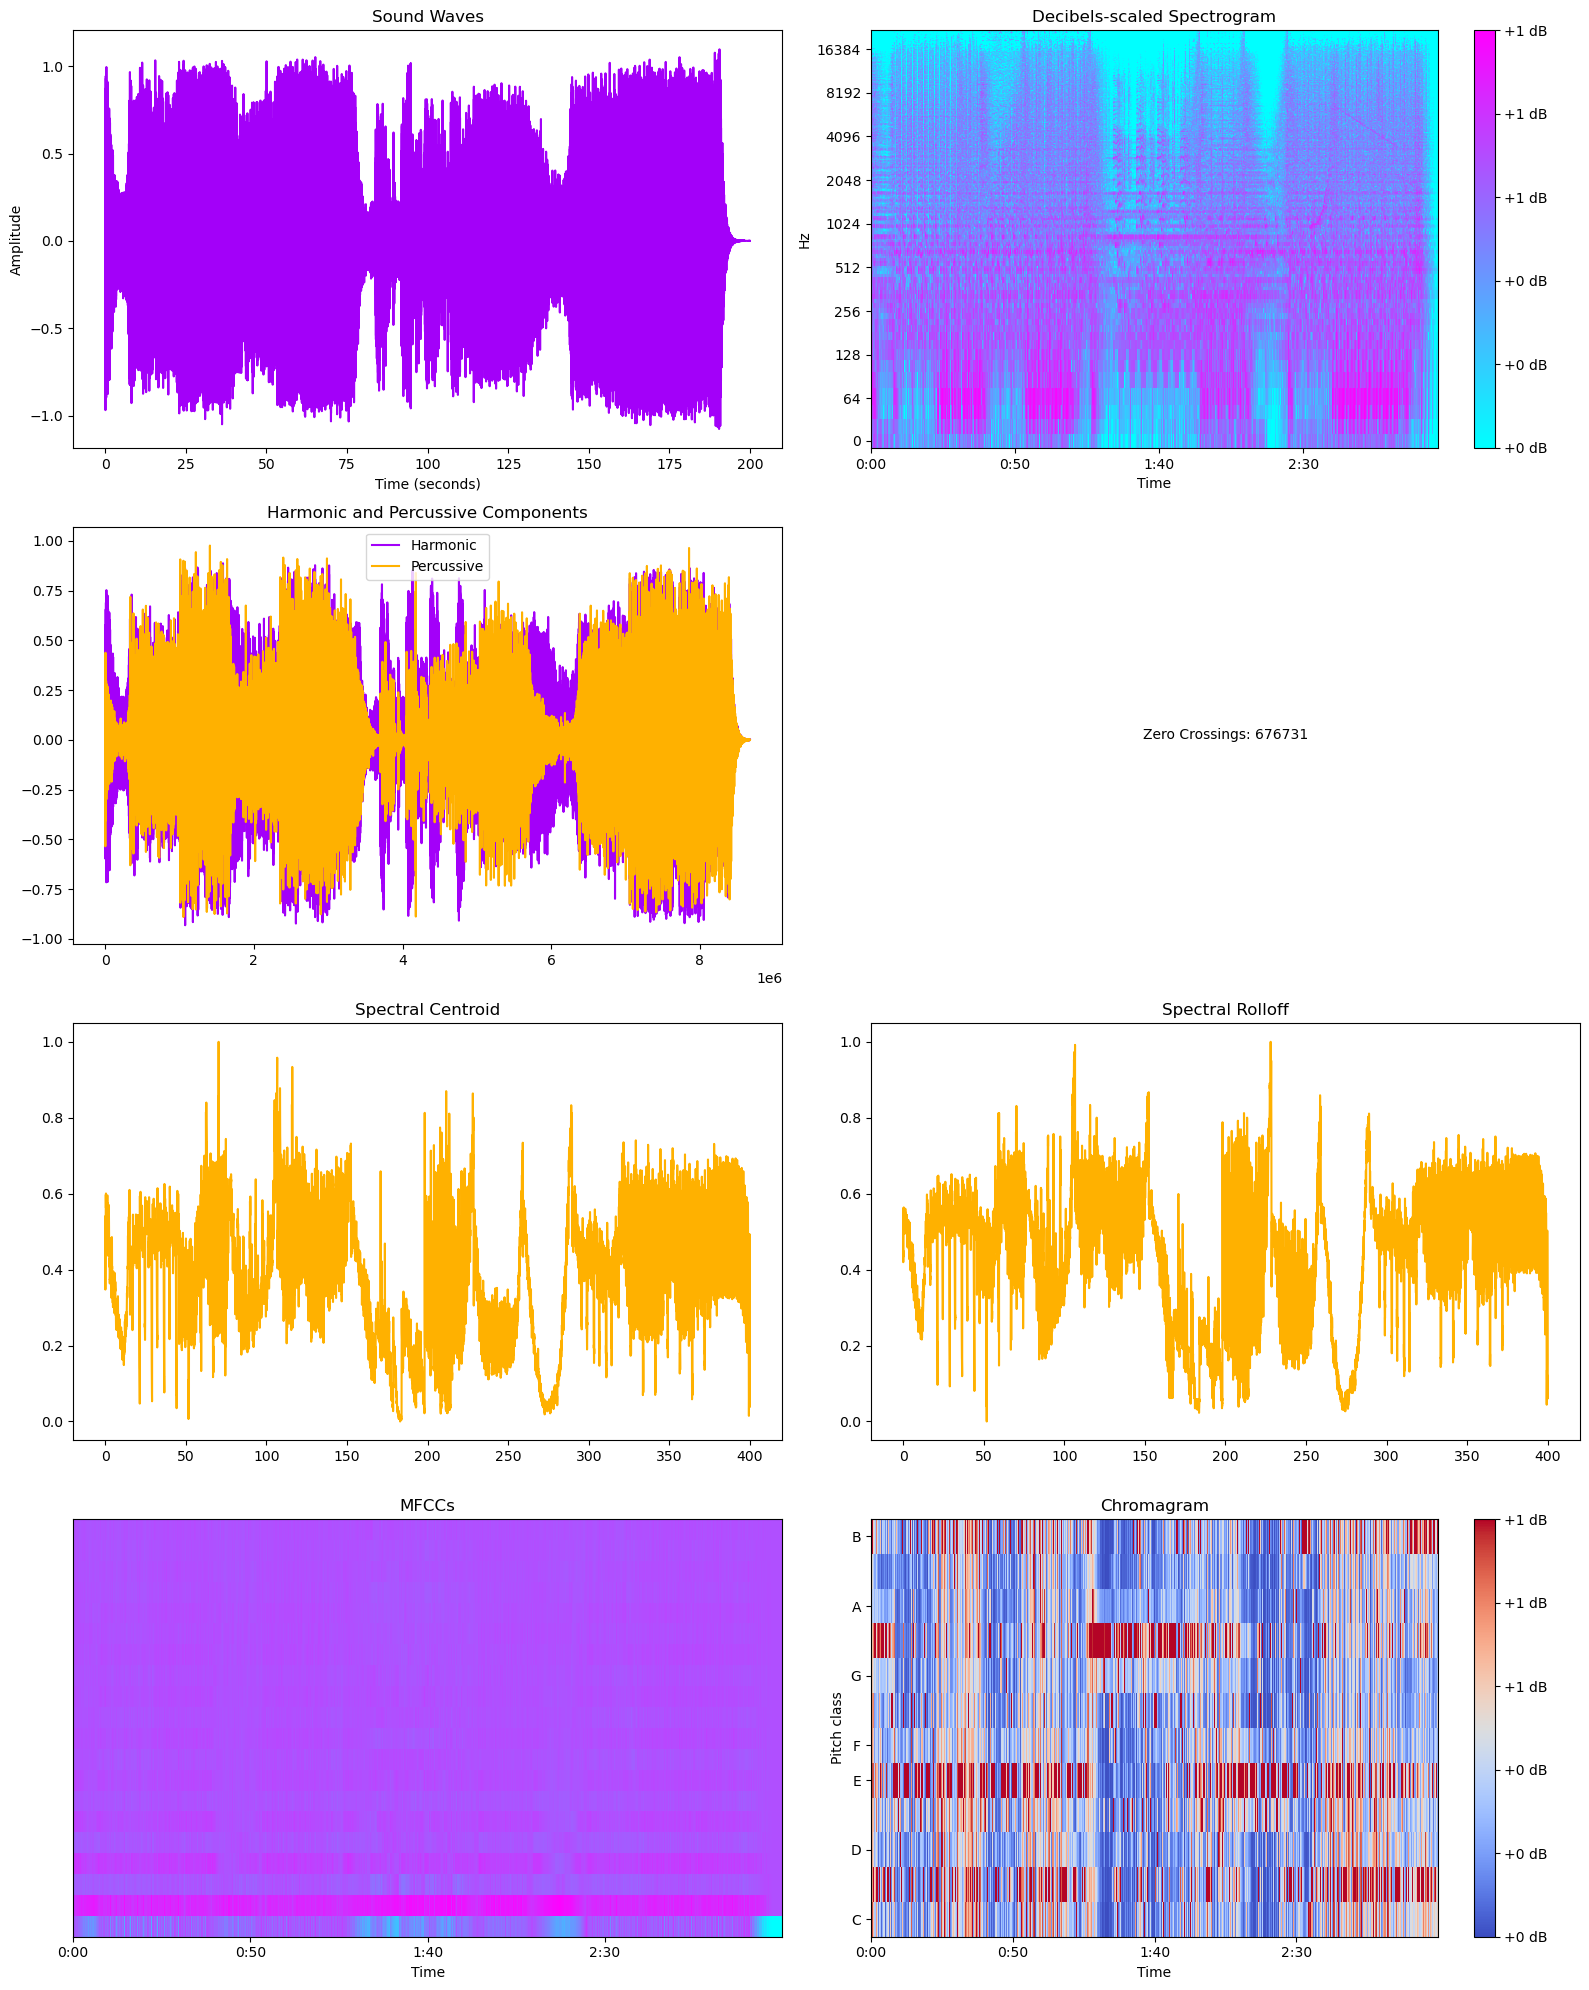

In [27]:
# get one song genre and show its plots
get_song_genre("Levels.mp3", randomForest_model, XGBoost_model, SVM_model, stacking_ensemble, displayPlots=True)


In [29]:
# try more songs outside of the database
filepaths = [ "Roxanne.mp3", "Fortunate Son.mp3", "Fallout.mp3" ]
for filepath in filepaths:
    print()
    print(filepath)
    get_song_genre(filepath, randomForest_model, XGBoost_model, SVM_model, stacking_ensemble)


Roxanne.mp3
-Random Forest Prediction: classical
-XGBoost Prediction: jazz
-SVM Prediction: classical
-Stacking Ensemble Prediction: classical

Fortunate Son.mp3
-Random Forest Prediction: classical
-XGBoost Prediction: classical
-SVM Prediction: classical
-Stacking Ensemble Prediction: classical

Fallout.mp3
-Random Forest Prediction: jazz
-XGBoost Prediction: jazz
-SVM Prediction: classical
-Stacking Ensemble Prediction: classical


In [33]:
# sets a couple of songs in each genre
genres =["pop", "metal", "disco", "blues", "reggae", "classical", "rock", "hiphop", "country", "jazz"]
for genre in genres:
    print(f"\n\nTesting files for {genre}")
    testFiles(genre)



Testing files for pop

genres_original/pop/pop.00003.wav
-Random Forest Prediction: classical
-XGBoost Prediction: classical
-SVM Prediction: classical
-Stacking Ensemble Prediction: classical

genres_original/pop/pop.00016.wav
-Random Forest Prediction: jazz
-XGBoost Prediction: pop
-SVM Prediction: classical
-Stacking Ensemble Prediction: classical

genres_original/pop/pop.00024.wav
-Random Forest Prediction: pop
-XGBoost Prediction: pop
-SVM Prediction: classical
-Stacking Ensemble Prediction: classical


Testing files for metal

genres_original/metal/metal.00003.wav
-Random Forest Prediction: classical
-XGBoost Prediction: pop
-SVM Prediction: classical
-Stacking Ensemble Prediction: classical

genres_original/metal/metal.00016.wav
-Random Forest Prediction: classical
-XGBoost Prediction: pop
-SVM Prediction: classical
-Stacking Ensemble Prediction: classical

genres_original/metal/metal.00024.wav
-Random Forest Prediction: classical
-XGBoost Prediction: pop
-SVM Prediction: clas